In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchvision
import tqdm

from matplotlib import cm
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
from torch import nn
from torchvision import transforms

%matplotlib inline

sns.set()

!rm -rf torchsummary
!git clone https://github.com/tyleryep/torch-summary.git  # Some fixes for torchsummary
!mv torch-summary/torchsummary torchsummary
!rm -rf torch-summary

from torchsummary import summary

Cloning into 'torch-summary'...
remote: Enumerating objects: 508, done.
remote: Counting objects: 100% (508/508), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 508 (delta 304), reused 373 (delta 172), pack-reused 0
Receiving objects: 100% (508/508), 113.59 KiB | 5.41 MiB/s, done.
Resolving deltas: 100% (304/304), done.


This notebook accompanies the [week15] practice. Refer to the classwork for more details.


Your last and ultimate task is to implement and train __Convolutional Conditional VAE__. Simple VAE is available in week 15. For details about conditional VAE one can refer to [week 15 lecture](https://github.com/ml-mipt/ml-mipt/tree/advanced/week15_generative) or [this habr post (ru)](https://habr.com/ru/post/331664/)

If it seems too easy, you can use [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset instead of MNIST.

The code in general duplicates the one from the in-class practice. 

Do not forget to __use GPU acceleration during training__.

__Currently you are using device:__

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(device)
device

device(type='cuda', index=0)

In [3]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - kernel_size) // stride + 1


def conv_transp2d_size_out(size, kernel_size, stride):
    return (size - 1) * stride + kernel_size


def rescale(image):
    image -= image.min()
    image /= image.max()
    return image


class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape

    def forward(self, x):
        return x.view(-1, *self.initial_shape)

__Data loading stuff is done for you ;)__

In [4]:
mnist_transformations = transforms.Compose(
    (
        transforms.ToTensor(),
        rescale
    )
)

In [5]:
BATCH_SIZE = 256
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [6]:
data_root = './'

In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

In [8]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

__The code below is simple VAE. Your task is to make in convolutional (both encoder and decoder) and add class label information.__

In [112]:
class ConvolutionalCVAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, input_shape, *, num_labels=10):
        super().__init__()
        self.register_buffer('one_hot_labels', torch.eye(num_labels, dtype=torch.float))
        self.num_labels = num_labels

        #input_dim = np.prod(input_shape)
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten()
        )

        sz = conv2d_size_out(input_shape[-1], 3, 2)
        sz = conv2d_size_out(sz, 3, 2)
        sz = conv2d_size_out(sz, 3, 2)

        input_linear = 64 * sz ** 2 + num_labels

        self.encoder_linear = nn.Sequential(
            nn.Linear(input_linear, intermediate_dims[0]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], intermediate_dims[1]),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3)
        )

        self.mu_repr = nn.Linear(intermediate_dims[1], latent_dim)
        self.log_sigma_repr = nn.Linear(intermediate_dims[1], latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_labels, intermediate_dims[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[1]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[1], intermediate_dims[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(intermediate_dims[0]),
            nn.Dropout(0.3),
            nn.Linear(intermediate_dims[0], 64 * sz * sz),
            RestoreShape((64, sz, sz)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2),
            nn.Sigmoid()
        )

        sz = conv_transp2d_size_out(sz, 3, 2)
        sz = conv_transp2d_size_out(sz, 5, 2)
        sz = conv_transp2d_size_out(sz, 4, 2)

    def _encode(self, x, label):
        labeled_convolution = torch.cat(
            (
                self.encoder_conv(x),
                label
            ),
            dim=1
        )
        latent_repr = self.encoder_linear(labeled_convolution)
        mu_values = self.mu_repr(latent_repr)
        log_sigma_values = self.log_sigma_repr(latent_repr)
        return mu_values, log_sigma_values, latent_repr

    def _reparametrize(self, sample, mu_values, log_sigma_values):
        if type(sample) is torch.Tensor or sample:
            return sample * torch.exp(log_sigma_values) + mu_values
        return mu_values

    def forward(self, x, label, raw_sample=None, *, decode_label=None):

        label = self.one_hot_labels[
            (label.squeeze().long() if type(label) is torch.Tensor else label) - 1
        ]
        if len(label.shape) == 1:
            label = label.unsqueeze(0)
        mu_values, log_sigma_values, latent_repr = self._encode(x, label)

        if raw_sample is None:
            raw_sample = torch.randn_like(mu_values)

        latent_sample = self._reparametrize(raw_sample, mu_values, log_sigma_values)

        if decode_label is None:
            decode_label = label
        else:
            decode_label = self.one_hot_labels[
                (decode_label.squeeze().long() if type(decode_label) is torch.Tensor else decode_label) - 1
            ]
            if len(decode_label.shape) == 1:
                decode_label = decode_label.unsqueeze(0)

        reconstructed_repr = self.decoder(
            torch.cat(
                (
                    latent_sample,
                    decode_label
                ),
                dim=1
            )
        )

        return reconstructed_repr, latent_sample, mu_values, log_sigma_values

    def transfer_style(self, x, *, from_label, to_label):
        with torch.no_grad():
            return self.forward(x, from_label, 0, decode_label=to_label)

In [113]:
def plot_digits(*args):
    args = tuple(x.squeeze() for x in args)
    n = min(x.shape[0] for x in args)

    fig = plt.figure(figsize=(2 * n, 2 * len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i * n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    return fig

In [114]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = ConvolutionalCVAE((256, 128), 5, example_x.shape).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(
    example_batch[0][:15].to(device),
    example_batch[1][:15].to(device)
)

summary(model, input_data=[example_x.shape, (1,)])
None

torch.Size([15, 10]) torch.Size([15, 1, 28, 28])
torch.Size([2, 10]) torch.Size([2, 1, 28, 28])
------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 16, 13, 13]          160
|    └─ReLU: 2-2                         [-1, 16, 13, 13]          --
|    └─Conv2d: 2-3                       [-1, 32, 6, 6]            4,640
|    └─ReLU: 2-4                         [-1, 32, 6, 6]            --
|    └─Conv2d: 2-5                       [-1, 64, 2, 2]            18,496
|    └─ReLU: 2-6                         [-1, 64, 2, 2]            --
|    └─Flatten: 2-7                      [-1, 256]                 --
├─Sequential: 1-2                        [-1, 128]                 --
|    └─Linear: 2-8                       [-1, 256]                 68,352
|    └─ReLU: 2-9          

In [115]:
kl_loss = (mu_values * mu_values + torch.exp(log_sigma_values) - 1 - log_sigma_values).sum() / (
    2 * mu_values.shape[0]
)
kl_loss

tensor(1.4549, device='cuda:0', grad_fn=<DivBackward0>)

In [116]:
test_batch = next(iter(test_loader))

In [117]:
def get_test_predictions(model, test_loader):

    model.eval()
    reconstructed_repr_list = []
    latent_samples_list = []
    mu_values_list = []
    log_sigma_values_list = []

    for test_batch in tqdm.notebook.tqdm(test_loader, leave=False):
        out = model(test_batch[0].to(device), test_batch[1][:, None].float().to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = (x.detach().cpu() for x in out)
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)

    return tuple(
        torch.cat(_list, dim=0)
        for _list in (reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list)
    )

In [118]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Size([256, 1, 28, 28])
torch.Size([256, 10]) torch.Siz

In [119]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 5

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, *, label=4, show=True):

    labels = [0] * 10
    labels[label - 1] = 1
    labels = torch.tensor(labels, device=next(model.parameters()).device, dtype=torch.float).view(1, -1)

    figure = np.zeros((digit_size * n,) * 2)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)

            x_decoded = model.decoder(torch.cat((z_torch, labels), dim=1)).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')

        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

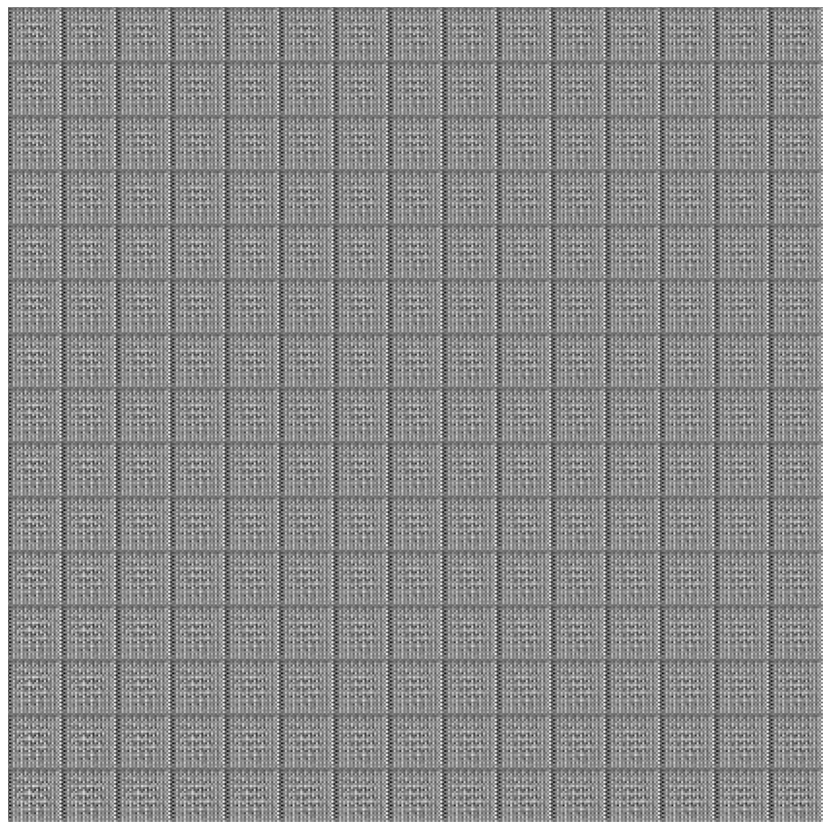

In [120]:
model.eval()
_img = draw_manifold(model, label=7, show=True)

In [121]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, label=6, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [122]:
def train(num_epochs):
    epochs = []
    figs = []
    latent_distrs = []
    for epoch_num in tqdm.notebook.trange(num_epochs):
        model.train()
        loss_accumulator = bce_acc = kl_acc = 0
        for batch_x, batch_label in tqdm.notebook.tqdm(train_loader, leave=False):
            batch_x = batch_x.to(device)
            batch_label = batch_label[:, None].float().to(device)

            predictions, latent, mu_values, log_sigma_values = model(batch_x, batch_label)

            kl_loss = (mu_values * mu_values + torch.exp(log_sigma_values) - 1 - log_sigma_values).sum() / (
                2 * mu_values.shape[0]
            )

            bce_loss = 28 * 28 * loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss) / 1568  # 2 * 28 ** 2
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item() / len(train_loader.dataset)
            bce_acc += bce_loss.item() / len(train_loader.dataset)
            kl_acc += kl_loss.item() / len(train_loader.dataset)

        if epoch_num % 5 == 0:
            print(
                f'Epoch num: {epoch_num}\n'
                f'Training loss={loss_accumulator:.4}, KL divergence={kl_acc:.4}, BCE Loss={bce_acc:.4}'
            )
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = (
                on_epoch_end(epoch_num)
            )
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [123]:
TRAIN = False

if TRAIN:
    epochs, figs, latent_distrs = train(500)
    model.eval()
    torch.save(model.state_dict(), 'model.dict')
else:
    model.load_state_dict(torch.load('model.dict'))

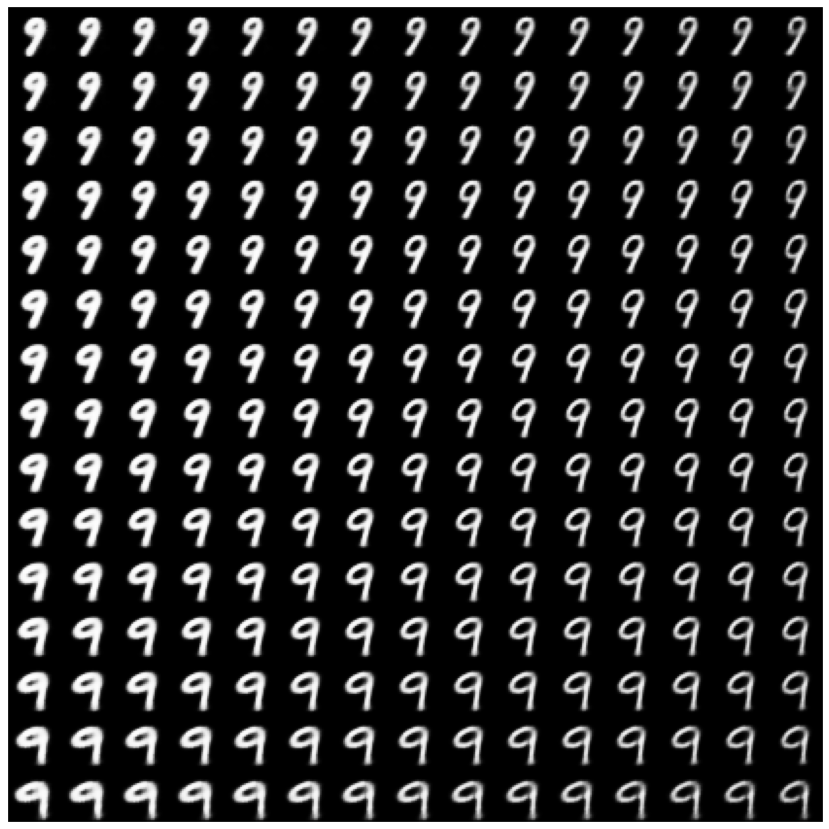

In [124]:
_img = draw_manifold(model, label=9, show=True)

torch.Size([1, 10]) torch.Size([1, 1, 28, 28])


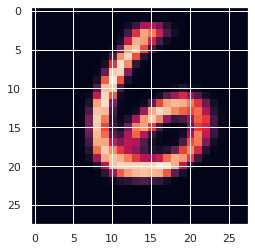

In [164]:
plt.imshow(
    model.transfer_style(
        test_loader.__iter__().__next__()[0][10:11].to(device),
        from_label=0,
        to_label=6
    )[0].cpu().numpy()[0, 0]
)

In [126]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

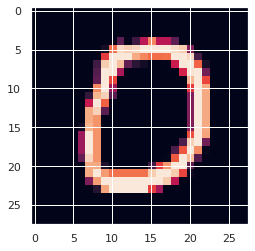

In [161]:
plt.imshow(test_loader.__iter__().__next__()[0][10].squeeze().numpy())

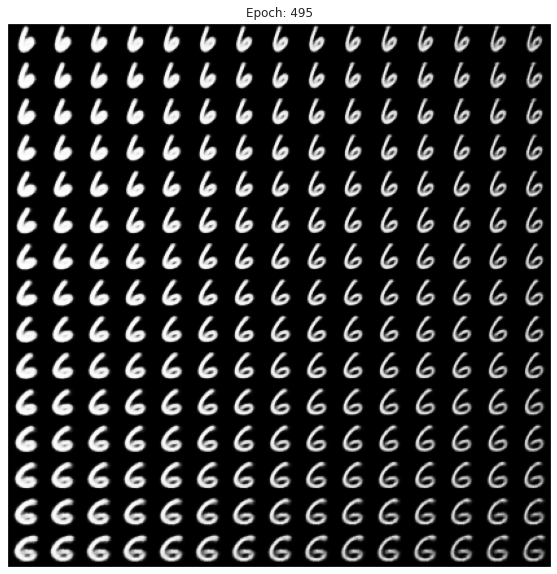

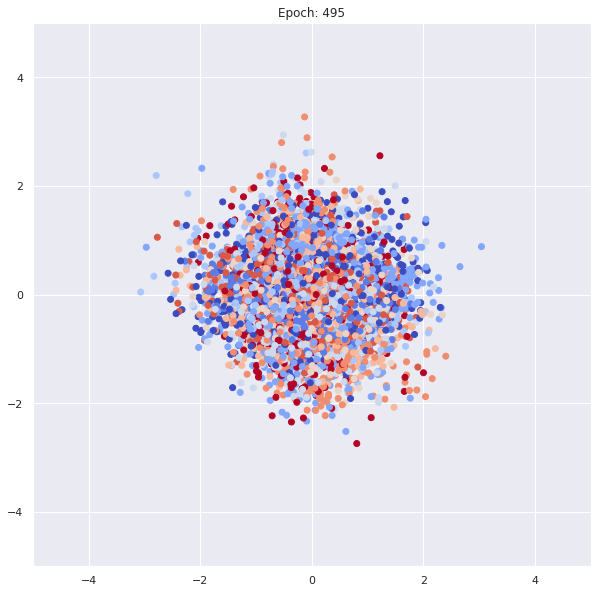

In [23]:
os.makedirs('my_figs', exist_ok=True)

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28, 28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title(f"Epoch: {epochs[0]}")

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title(f"Epoch: {epochs[i]}")
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title(f"Epoch: {epochs[0]}")
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title(f"Epoch: {epochs[i]}")
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    anim.save(fname, dpi=80, writer='imagemagick')

make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10, 10)))
make_2d_scatter_gif(
    tuple(x[0].numpy() for x in latent_distrs),
    epochs,
    test_labels,
    "./my_figs/z_distr2.gif",
    plt.figure(figsize=(10, 10))
)

You can find your brand gifs in `./my_figs/` directory ;)

Optionally you can also implement GAN for this task. Good luck!